In [193]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene, WireMesh
from meshmaker.meta import Stairs, Railings
from meshmaker.seam import Seam
from meshmaker.tform import TForm
from meshmaker.loop import Loops
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.planargraph import planargraph
#from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, isnear, near, loopO
from meshmaker.geometry import batch, slide, isnear, near, loop_normal, loop_area, bbox
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader, LazyMaterials
from meshmaker.plt import *
from collections import defaultdict
import json
from functools import partial
from contextlib import contextmanager
import itertools as it

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.X())])

In [2]:
class Platforms(MetaMesh):
    
    height = 0.04
    
    def scene(self):
        meshes = []
        for (a, b, c, d), height in self.control._platforms:
            a = self.control.vertices[a]
            b = self.control.vertices[b]
            c = self.control.vertices[c]
            d = self.control.vertices[d]
            height = (self.height if height is None else height)
            dZ = vec3.Z(-height)
            e, f, g, h = [a + dZ, b + dZ, c + dZ, d + dZ]
            mesh = Mesh()
            meshes.append(mesh)
            mesh.af([a, b, c, d])
            mesh.af([h, g, f, e])
            mesh.af([e, f, b, a])
            mesh.af([f, g, c, b])
            mesh.af([g, h, d, c])
            mesh.af([h, e, a, d])
            if height < 0:
                mesh.fp()
            mesh.uvs = mesh.vertex_uvs(seams=mesh.angle_seams(), S=vec3.U(2))
        return TForm.from_meshes(*meshes, texture='generic_13')

# Some classes to faciliate WFC algorithm

In [3]:
class Wavefunction:

    """Class responsible for storing which tiles are where"""

    @staticmethod
    def mk(size, weights):
        lattice = Wavefunction.init_coefficients(size, weights.keys())
        return Wavefunction(lattice, weights)

    @staticmethod
    def init_coefficients(size, tiles):
        lattice = []
        for x in range(size[0]):
            row = []
            for y in range(size[1]):
                col = []
                row.append(col)
                for z in range(size[2]):
                    col.append(set(tiles))
            lattice.append(row)
        return np.array(lattice)

    def __init__(self, lattice, weights):
        self.lattice = lattice
        self.weights = weights

    def get(self, co_ords):
        """Returns the set of possible tiles at `co_ords`"""
        x, y, z = co_ords
        return self.lattice[x, y, z]

    def get_collapsed(self, co_ords):
        """Returns the only remaining possible tile at `co_ords`.
        If there is not exactly 1 remaining possible tile then
        this method raises an exception.
        """
        opts = self.get(co_ords)
        #assert(len(opts) == 1)
        #return next(iter(opts))
        try:
            assert(len(opts) == 1)
            return next(iter(opts))
        except AssertionError:
            return
            
    def get_all_collapsed(self):
        """Returns a 2-D matrix of the only remaining possible
        tiles at each location in the wavefunction. If any location
        does not have exactly 1 remaining possible tile then
        this method raises an exception.
        """
        nx, ny, nz = self.lattice.shape
        collapsed = []
        for x in range(nx):
            row = []
            collapsed.append(row)
            for y in range(ny):
                col = []
                row.append(col)
                for z in range(nz):
                    tile = self.get_collapsed((x, y, z))
                    #if tile is not None:
                    col.append(tile)
        return np.array(collapsed)

    def shannon_entropy(self, co_ords):
        """Calculates the Shannon Entropy of the wavefunction at
        `co_ords`.
        """
        x, y, z = co_ords
        sum_of_weights = 0
        sum_of_weight_log_weights = 0
        for opt in self.lattice[x, y, z]:
            weight = self.weights[opt]
            sum_of_weights += weight
            sum_of_weight_log_weights += weight * np.log(weight)
        return np.log(sum_of_weights) - (sum_of_weight_log_weights / sum_of_weights)

    def is_fully_collapsed(self):
        for x, row in enumerate(self.lattice):
            for y, col in enumerate(row):
                for z, options in enumerate(col):
                    if len(options) > 1:
                        return False
        return True

    def collapse(self, co_ords):
        """Collapses the wavefunction at `co_ords` to a single, definite
        tile. The tile is chosen randomly from the remaining possible tiles
        at `co_ords`, weighted according to the Wavefunction's global
        `weights`.
        This method mutates the Wavefunction, and does not return anything."""
        x, y, z = co_ords
        opts = self.lattice[x, y, z]
        valid_weights = {tile: weight for tile, weight in self.weights.items() if tile in opts}
        total_weights = sum(valid_weights.values())
        rnd = np.random.random() * total_weights
        chosen = None
        for tile, weight in valid_weights.items():
            rnd -= weight
            if rnd < 0:
                chosen = tile
                break
        self.lattice[x, y, z] = set((chosen, ))

    def constrain(self, co_ords, forbidden_tile):
        """Removes `forbidden_tile` from the list of possible tiles at `co_ords`.
        This method mutates the Wavefunction, and does not return anything."""
        x, y, z = co_ords
        self.lattice[x, y, z].remove(forbidden_tile)
        #print('constrain', x, y, z)

In [19]:
class WaveModel:
    """Class responsible for running wavefunction collapse algorithm"""

    @staticmethod
    def valid_dirs(cur_co_ord, matrix_size):
        """Returns the valid directions from `cur_co_ord` in a matrix
        of `matrix_size`. Ensures that we don't try to take step to the
        left when we are already on the left edge of the matrix."""
        x, y, z = cur_co_ord
        nx, ny, nz = matrix_size
        dirs = []
        if x > 0:
            dirs.append(LEFT)
        if x < nx - 1:
            dirs.append(RIGHT)
        if y > 0:
            dirs.append(BACK)
        if y < ny - 1:
            dirs.append(FRONT)
        if z > 0:
            dirs.append(BOTTOM)
        if z < nz - 1:
            dirs.append(TOP)
        return dirs

    def __init__(self, output_size, compatibilities, weights):
        self.output_size = output_size
        self.compatibilities = compatibilities
        self.weights = weights
        #self.wavefunction = Wavefunction.mk(output_size, weights)

    def run(self):
        """Collapses the Wavefunction until it is fully collapsed,
        then returns a 2-D matrix of the final, collapsed state.
        """
        self.wavefunction = Wavefunction.mk(self.output_size, self.weights)
        iteration = 0
        while not self.wavefunction.is_fully_collapsed():
            self.iterate()
            iteration += 1
        print(f'{iteration} iterations')
        return self.wavefunction.get_all_collapsed()

    def run_until(self, max_attempts=100):
        attempt = 0
        success = False
        while not success:
            collapsed = self.run()
            attempt += 1
            if collapsed.dtype == np.int:
                success = True
            print(f'Run attempt {attempt}: {"Success" if success else "Failure"}')
            if attempt == max_attempts:
                collapsed = None
                break
        return collapsed

    def iterate(self):
        """Performs a single iteration of the Wavefunction Collapse
        Algorithm.
        """
        # 1. Find the co-ordinates of minimum entropy
        co_ords = self.min_entropy_co_ords()
        # 2. Collapse the wavefunction at these co-ordinates
        self.wavefunction.collapse(co_ords)
        # 3. Propagate the consequences of this collapse
        self.propagate(co_ords)

    def propagate(self, co_ords):
        """Propagates the consequences of the wavefunction at `co_ords`
        collapsing. If the wavefunction at (x,y) collapses to a fixed tile,
        then some tiles may not longer be theoretically possible at
        surrounding locations.
        This method keeps propagating the consequences of the consequences,
        and so on until no consequences remain.
        """
        stack = [co_ords]

        while len(stack) > 0:
            cur_coords = stack.pop()
            # Get the set of all possible tiles at the current location
            cur_possible_tiles = self.wavefunction.get(cur_coords)

            # Iterate through each location immediately adjacent to the
            # current location.
            for d in self.valid_dirs(cur_coords, self.output_size):
                other_coords = (cur_coords[0] + d[0], cur_coords[1] + d[1], cur_coords[2] + d[2])

                # Iterate through each possible tile in the adjacent location's
                # wavefunction.
                for other_tile in set(self.wavefunction.get(other_coords)):
                    # Check whether the tile is compatible with any tile in
                    # the current location's wavefunction.
                    other_tile_is_possible = any([
                        ((cur_tile, other_tile, d) in self.compatibilities)
                        for cur_tile in cur_possible_tiles
                    ])
                  
                    # If the tile is not compatible with any of the tiles in
                    # the current location's wavefunction then it is impossible
                    # for it to ever get chosen. We therefore remove it from
                    # the other location's wavefunction.
                    if not other_tile_is_possible:
                        self.wavefunction.constrain(other_coords, other_tile)
                        stack.append(other_coords)

    def min_entropy_co_ords(self):
        """Returns the co-ords of the location whose wavefunction has
        the lowest entropy.
        """
        min_entropy = None
        min_entropy_coords = None
                  
        # TODO: try to modify this to only consider locations adjacent to
        #       collapsed locations to avoid failures...

        nx, ny, nz = self.output_size
        for x in range(nx):
            for y in range(ny):
                for z in range(nz):
                    if len(self.wavefunction.get((x, y, z))) == 1:
                        continue

                    entropy = self.wavefunction.shannon_entropy((x, y, z))
                    # Add some noise to mix things up a little
                    entropy_plus_noise = entropy - (np.random.random() / 1000)
                    if min_entropy is None or entropy_plus_noise < min_entropy:
                        min_entropy = entropy_plus_noise
                        min_entropy_coords = (x, y, z)

        return min_entropy_coords

In [148]:
def render(lattice, tiles):
    print(lattice)
    tf = TForm()
    nx, ny, nz = lattice.shape
    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                # need a copy of the tform, or to use its models...
                tiletf = TForm(t=vec3(x, y, z), s=vec3.U(0.5))
                tileix = lattice[x, y, z]
                if tileix is not None:
                    tiletf.add(tiles[tileix].cp())
                tf.add(tiletf)
    show(MetaScene(tf))


BOTTOM, TOP = tuple(vec3.Z(-1)), tuple(vec3.Z(+1))
BACK, FRONT = tuple(vec3.Y(-1)), tuple(vec3.Y(+1))
LEFT, RIGHT = tuple(vec3.X(-1)), tuple(vec3.X(+1))
        

class Tile:
    
    def __init__(self, index, 
                 bottom_sock=None, top_sock=None,
                 back_sock=None, front_sock=None,
                 left_sock=None, right_sock=None,
                 bottom_mode='==', top_mode='==',
                 back_mode='==', front_mode='==',
                 left_mode='==', right_mode='=='):
        self.index = index
        self.socket = {
            BOTTOM: bottom_sock, TOP: top_sock,
            BACK: back_sock, FRONT: front_sock,
            LEFT: left_sock, RIGHT: right_sock,
        }
        self.modes = {
            BOTTOM: bottom_mode, TOP: top_mode,
            BACK: back_mode, FRONT: front_mode,
            LEFT: left_mode, RIGHT: right_mode,
        }
    
    surface_pairs = [
        (BOTTOM, TOP),
        (TOP, BOTTOM),
        (BACK, FRONT),
        (FRONT, BACK),
        (LEFT, RIGHT),
        (RIGHT, LEFT),
    ]
    
    def compatibilities(self, other, compatibilities=None):
        """Generate compatibilies of this tile and another"""
        if compatibilities is None:
            compatibilities = set()
        for x, y in self.surface_pairs:
            if self.compatible(self.socket[x], other.socket[y],
                               self.modes[x], other.modes[y]):
                compatibilities.add((self.index, other.index, x))
        return compatibilities   
        
    def compatible(self, u, v, u_mode, v_mode):
        """Compute compatibility between two sockets"""
        if any((u_mode == v_mode == '==',
                u_mode == v_mode == '<=',
                u_mode == v_mode == '>=')):
            if isinstance(u, planargraph) and isinstance(v, planargraph):
                return u.eq(v)
            elif isinstance(u, np.array) and isinstance(v, np.array):
                return (u == v).all()
            else:
                print('new ness!', u, v, u_mode, v_mode)
                raise
        else:
            if isinstance(u, planargraph) and isinstance(v, planargraph):
                if   u_mode == '<=' and v_mode == '>=':
                    return u.lt(v)
                elif u_mode == '>=' and v_mode == '<=':
                    return u.gt(v)
                else:
                    print('new ness!', u, v, u_mode, v_mode)
                    raise
            else:
                print('new ness!', u, v, u_mode, v_mode)
                raise

    @classmethod
    def from_mesh(cls, mesh, index=0):
        """Generate tile from mesh, inferring compatibility from geometry"""
        tile_bbox = Mesh.cube_mesh()
        tile = cls(index, [], [], [], [], [], [])
        mesh_fN =      mesh.face_normals()
        bbox_fN = tile_bbox.face_normals()
        for bf, bface in tile_bbox:
            bfN = bbox_fN[bf]
            for mf, mface in mesh:
                mfN = mesh_fN[mf]
                if bfN.isnear(mfN):
                    dN = (tile_bbox.vertices[bface[0]].dot(bfN)-
                               mesh.vertices[mface[0]].dot(bfN))
                    if isnear(dN, 0):
                        tile.socket[tuple(bfN)].append(mf)
            mfaces = tile.socket[tuple(bfN)]
            if mfaces:
                loops = []
                #q = quat.toxy((bfN if (min(tuple(bfN)) > 0) else (bfN * -1)))
                if isnear(bfN.xy().mag(), 1):
                    q = quat.toxy(bfN)
                else:
                    q = quat.O()
                for face in mfaces:
                    face = [mesh.vertices[v].cp() for v in mesh.faces[face]]
                    (bfN * (-face[0].dot(bfN))).trnps(face)
                    q.rot(face)
                    loops.append(face)
            else:
                loops = []
            tile.socket[tuple(bfN)] = planargraph(loops=loops)

        tile.modes[BOTTOM] = '<='
        tile.modes[TOP] = '>='

        tile.bbox = tile_bbox
        return tile

# Using WFC pieces

In [149]:
class TileCollection:

    @classmethod
    def demo(cls, nx=3, ny=3, nz=3):
        """Render realization of the collections prefabs"""
        print('Generating Prefabs')
        tiles, compatibilities, weights = cls().prefabs()
        #print('Compatibilities', compatibilities)
        print('Generating Model Output')
        model = WaveModel(( nx, ny, nz), compatibilities, weights)
        #lattice = model.run()
        lattice = model.run_until()
        print('Rendering output')
        render(lattice, tiles)

    def __init__(self):
        self.ntile = 0
    
    def _tile(self, c):
        """Initialize matrices to eventually represent compatibility"""
        # TODO: to support multiple TileCollections, share ntile?
        tile = Tile(self.ntile,
                    np.zeros((len(c._X) - 1, len(c._Y) - 1)),
                    np.zeros((len(c._X) - 1, len(c._Y) - 1)),
                    np.zeros((len(c._X) - 1, len(c._Z) - 1)),
                    np.zeros((len(c._X) - 1, len(c._Z) - 1)),
                    np.zeros((len(c._Y) - 1, len(c._Z) - 1)),
                    np.zeros((len(c._Y) - 1, len(c._Z) - 1)))
        self.ntile += 1
        return tile

    def _lattice(self, nx, ny, nz):
        """Initialize control mesh, tile, and mapping  between them"""
        c = Mesh.lattice(nx, ny, nz)
        c._skins = [WireMesh]
        c._blocks = []
        c._stairs = []
        c._railings = []
        c._platforms = []
        v = lambda x, y, z: c._fp(vec3(x, y, z))
        t = self._tile(c)
        return c, v, t
    
    def _tf(self, c, **kws):
        """Wrap control mesh with parameterizations and tform"""
        return TForm(metas=[skin(c) for skin in c._skins], **kws)
        #return TForm(metas=[Platforms(c), Stairs(c), Railings(c), WireMesh(c)], **kws)

    def prefabs(self):
        """Generate all prefab tiles, compatibilities, and weights"""
        compatibilities = set()
        weights = {}
        tiles = self.tiles()
        for x in tiles:
            weights[x.tile.index] = 1.0
            for y in tiles:
                x.tile.compatibilities(y.tile, compatibilities)
        return tiles, compatibilities, weights

    def tiles(self):
        """Generate prefab tiles"""
        raise NotImplementedError

        
        
        

    def platform(self, c, t, x, y, z, theta=0, l=1, w=1, h=None):
        """Add platform to control mesh"""
        q = quat.rotz(-theta)
        q.rot(c.vertices)
        v = lambda x, y, z: c._fp(vec3(c._X[x], c._Y[y], c._Z[z]))
        c._platforms.append(((v(     x,     y, z),
                              v( x + l,     y, z),
                              v( x + l, y + w, z),
                              v(     x, y + w, z)), h))
        if not Platforms in c._skins:
            c._skins.append(Platforms)
        q = q.fp()
        q.rot(c.vertices)
        self.platform_sockets(c, t)
        
    def platform_sockets(self, c, t):
        """Register socket compatibility for the latest platform"""
        # need x, y, z coords of lexicographic bottom-left corner
        aaa, bbb = bbox([c.vertices[j] for j in c._platforms[-1][0]])
        x, y, z = (np.where(aaa.x == c._X)[0][0],
                   np.where(aaa.y == c._Y)[0][0],
                   np.where(aaa.z == c._Z)[0][0])
        # z is treated differently here
        if z == 0:
            t.socket[BOTTOM][x, y] = 1
        elif z == c._Z.shape[0] - 2:
            t.socket[TOP][x, y] = 1
        # x and y are treated the same
        if y == 0:
            t.socket[BACK][x, z] = 1
        elif y == c._Y.shape[0] - 2:
            t.socket[FRONT][x, z] = 1
        if x == 0:
            t.socket[LEFT][y, z] = 1
        elif x == c._X.shape[0] - 2:
            t.socket[RIGHT][y, z] = 1
            
            
        
    def _tile_from_mesh(self, mesh):
        tile = Tile.from_mesh(mesh, self.ntile)
        self.ntile += 1
        return tile

In [190]:
# would like MetaMesh subclass which just transforms associated regular mesh

class LatticeTF(MetaMesh):
    
    def scene(self):
        return TForm.from_meshes(*self.control._meshes, texture=self.texture)

# block stacks

In [151]:
def plot_sockets(mesh, tile):
    #tmesh = Mesh()
    
    f, axes = plot(6, 1, (6, 6 * 6))
    for (d, s), ax in zip(tile.socket.items(), axes):
        plot_pg(ax, s)
        ax.set_title(f'{d}')
    
    #show(mesh)

In [152]:
def contains(a, b):
    """Does a contain b"""
    if loop_normal(a).z < 0:                                                       
        a = a[::-1]                                                                
    inside = all(p.inbxy(a, True) for p in b)                                      
    #return inside and (loop_area(a) > loop_area(b))
    return inside and (loop_area(a) >= loop_area(b))

def lt(self, o):
    """Less than or equal to check"""
    sloop = self.polygon()[0]
    oloop =    o.polygon()[0]
    if not sloop:
        return True
    elif not oloop:
        return False
    else:
        return contains(oloop, sloop)

def gt(self, o):
    """Less than or equal to check"""
    sloop = self.polygon()[0]
    oloop =    o.polygon()[0]
    if not oloop:
        return True
    elif not sloop:
        return False
    else:
        return contains(sloop, oloop)

def eq(self, o):
    """Equality check"""
    sloop = self.polygon()[0]
    oloop =    o.polygon()[0]
    if not sloop or not oloop:
        return not sloop and not oloop
    else:
        return contains(sloop, oloop) and contains(oloop, sloop)


planargraph.lt = lt
planargraph.gt = gt
planargraph.eq = eq

In [209]:
generics = {}
for j in range(14):
    generics[j] = f'generic_{j}'

#generics = [t for t, p in LazyMaterials.list('../resources/textures/') if 'generic_' in t]
#generics = {j: t for j, t in enumerate(generics)}

n_generics = len(generics)

In [210]:
print(generics)

{0: 'generic_0', 1: 'generic_1', 2: 'generic_2', 3: 'generic_3', 4: 'generic_4', 5: 'generic_5', 6: 'generic_6', 7: 'generic_7', 8: 'generic_8', 9: 'generic_9', 10: 'generic_10', 11: 'generic_11', 12: 'generic_12', 13: 'generic_13'}


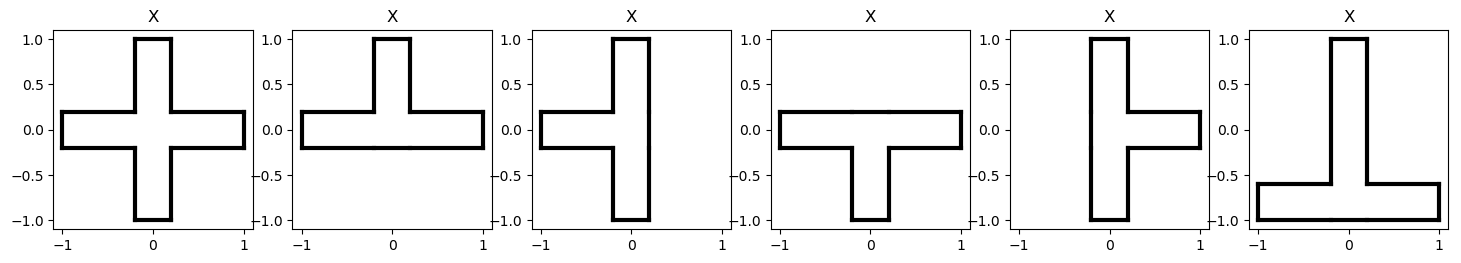

In [291]:
class GenericShapes(Laziness):
    
    codes = [
        'O',
        'L',
        'T',
    ]
    
    def _O(self, r=1, **kws):
        return [(-r,-r), ( r,-r), ( r, r), (-r, r)]
    
    def _L(self, r=0.5, o=0, **kws):
        return [(-1+o,  -1), (  1,  -1), (   1, 1-o),
                ( 1-r, 1-o), (1-r,-1+r), (-1+o,-1+r)]
    
    def _T(self, a=1, b=1, c=1, y=0, r=0.5, **kws):
        return [
            (-r,-r+y), (-r,-a+y), ( r,-a+y), ( r,-r+y),
            ( b,-r+y), ( b, r+y),
            (-c, r+y), (-c,-r+y),
        ]
    
    def _X(self, a=0, b=0, c=0, d=0, x=0, y=0, r=0.5, **kws):
        loop = []
        loop.append((-r,-r))
        if a > r:
            loop.append((-r,-a))
            loop.append(( r,-a))
        loop.append(( r,-r))
        if b > r:
            loop.append(( b,-r))
            loop.append(( b, r))
        loop.append(( r, r))
        if c > r:
            loop.append(( r, c))
            loop.append((-r, c))
        loop.append((-r, r))
        if d > 0:
            loop.append((-d, r))
            loop.append((-d,-r))
        loop = [(u + x, v + y) for u, v in loop]
        return loop
    
    def shape(self, code='O', **kws):
        xys = getattr(self, f'_{code}')(**kws)
        return [vec3(x, y, 0) for x, y in xys]

    def __init__(self):
        super().__init__(self.shape)
        
    @classmethod
    def demo(cls, codes=None, **kws):
        inst = cls()
        codes = cls.codes if codes is None else codes
        f, axes = plot(1, len(codes), figsize=(3 * len(codes), 3))
        axes = [axes] if len(codes) < 2 else axes
        for ax, code in zip(axes, codes):
            if isinstance(code, tuple):
                code, kws = code
            shape = inst.shape(code, **kws)
            plot_loop(ax, shape)
            ax.set_title(code)
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.set_aspect(1)


codes = [
    # pluses
    ('X', dict(a=1.0, b=1.0, c=1.0, d=1.0, r=0.2)),

    # short tees
    ('X', dict(a=0.0, b=1.0, c=1.0, d=1.0, r=0.2)),
    ('X', dict(a=1.0, b=0.0, c=1.0, d=1.0, r=0.2)),
    ('X', dict(a=1.0, b=1.0, c=0.0, d=1.0, r=0.2)),
    ('X', dict(a=1.0, b=1.0, c=1.0, d=0.0, r=0.2)),
    
    # long tees
    ('X', dict(a=0.0, b=1.0, c=2.0-0.2, d=1.0, y=-1+0.2, r=0.2)),
    #('X', dict(a=1.0, b=0.0, c=1.0, d=1.0, r=0.2)),
    #('X', dict(a=1.0, b=1.0, c=0.0, d=1.0, r=0.2)),
    #('X', dict(a=1.0, b=1.0, c=1.0, d=0.0, r=0.2)),
    
    # els
    #('X', dict(a=0.0, b=0.0, c=1.0, d=1.0, r=0.2)),
    #('X', dict(a=1.0, b=0.0, c=0.0, d=1.0, r=0.2)),
    #('X', dict(a=1.0, b=1.0, c=0.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=1.0, c=1.0, d=0.0, r=0.2)),
    
    # eyes
    #('X', dict(a=1.0, b=0.0, c=1.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=1.0, c=0.0, d=1.0, r=0.2)),

    # sticks
    #('X', dict(a=1.0, b=0.0, c=0.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=1.0, c=0.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=0.0, c=1.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=0.0, c=0.0, d=1.0, r=0.2)),

    #('X', dict(a=0.0, b=0.0, c=0.0, d=0.0, r=0.2)),
    #('X', dict(a=0.0, b=0.0, c=0.0, d=0.0, r=0.2)),
]
gs = GenericShapes()
gs.demo(codes)

In [212]:
class BlockStacks(TileCollection):

    def _tf(self, mesh, **kws):
        t = self._tile_from_mesh(mesh)
        c = mesh
        c._skins = [partial(LatticeTF,
                            texture=generics[t.index % n_generics])]
        c._meshes = [mesh]
        u = super()._tf(c, **kws)
        c = t.bbox
        c._skins = [WireMesh]
        v = super()._tf(c, **kws)
        return TForm(children=[u, v], tile=t)
        
    def tiles(self):
        return [self._tf(mesh) for mesh in self.meshes()]

    def tee(self):
        h = 0
        w = 0.2
        loop = [
            ( 1,-w,-h),
            ( 1, w,-h),
            ( w, w,-h),
            ( w, 1,-h),
            (-w, 1,-h),
            (-w, w,-h),
            (-1, w,-h),
            (-1,-w,-h),
        ]
        loop = [vec3(*p) for p in loop]
        mesh = Mesh.prism(loop, 2)
        return mesh
        
    def el(self, r=0.2, o=0.0):
        l = [(-1+o,  -1), (  1,  -1), (   1, 1-o),
             ( 1-r, 1-o), (1-r,-1+r), (-1+o,-1+r)]
        return Mesh.prism([vec3(x, y, 0) for x, y in l], 2)

    def tees(self):
        for a in range(4):
            mesh = self.tee()
            quat.rotz(np.pi * (a / 2)).rot(mesh.vertices)
            yield mesh
        mesh = Mesh.cube_mesh()
        vec3(0.2, 0.2, 1.0).sclps(mesh.vertices)
        yield mesh

    def els(self):
        for o in (0.0, 0.2, 0.4, 0.6, 0.8):
            for r in (0.2, 0.4, 0.6, 0.8):
                for a in range(4):
                    mesh = self.el(r=r, o=o)
                    quat.rotz(np.pi * (a / 2)).rot(mesh.vertices)
                    yield mesh
        
    def blocks(self):
        loop = [(-1,-1), ( 1,-1), ( 1, 1), (-1, 1)]
        loop = [vec3(x, y, 0) for x, y in loop]
        loop = Loops((loop, ), ).offset(0.3).loops[0]
        yield Mesh.prism(loop, 2)
        for j in range(5):
            loop = Loops((loop, ), ).offset(0.1).loops[0]
            yield Mesh.prism(loop, 2)

    def meshes(self):        
        meshes = []
        meshes.extend(self.blocks())
        meshes.extend(self.tees())
        meshes.extend(self.els())
        #meshes.extend(self.walls())
        return meshes


BlockStacks.demo(4, 8, 3)

Generating Prefabs
Generating Model Output
65 iterations
Run attempt 1: Success
Rendering output
[[[22 54 86]
  [21 53 61]
  [22 50 62]
  [21 69 69]
  [14 62 62]
  [13 29 45]
  [22 38 54]
  [21 45 61]]

 [[19 67 75]
  [20 48 76]
  [19 43 75]
  [20 68 84]
  [11 59 75]
  [12 28 60]
  [19 27 59]
  [20 84 84]]

 [[22 62 78]
  [21 45 77]
  [18 50 82]
  [17 65 77]
  [18 66 82]
  [17 33 65]
  [22 38 70]
  [21 85 81]]

 [[19 59 75]
  [20 52 68]
  [15 43 59]
  [16 80 76]
  [15 79 75]
  [16 48 76]
  [19 47 79]
  [20 84 76]]]
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f871092e1d0>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f871092e080>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f871092e240>
Loaded texture: generic_1 (../resources/textures/generics/generic_1.png)
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_0 (../resources/textur

# platforms, stairs, railings

In [90]:
class Circulations(TileCollection):
    
    def flight(self, c, t, x, y, p, q):
        """Add flight of stairs to control mesh"""
        v = lambda x, y, z: c._fp(vec3(c._X[int(x)],
                                       c._Y[int(y)],
                                       c._Z[int(z)]))
        c._stairs.append(((v(x.x, x.y, x.z), v(y.x, y.y, y.z)),
                          (v(p.x, p.y, p.z), v(q.x, q.y, q.z))))
        if not Stairs in c._skins:
            c._skins.append(Stairs)

    def tiles(self):
        """Generate all prefab tiles"""
        tiles = []
        #tiles.extend(self._5x5x5_z0(1))
        #tiles.extend(self._5x5x5_z0(2))
        tiles.extend(self._5x5x5_z0(1, 2))
        tiles.extend(self._5x5x5_z0z1(1, 2))
        return tiles

    def _5x5x5_X(self, c, v, t, z=0):
        for x in (1, 2):
            for y in (0, 3):
                self.platform( c, t, x, y, z)
        for x in (0, 3):
            for y in (1, 2):
                self.platform( c, t, x, y, z)
        for x in (1, 2):
            for y in (1, 2):
                self.platform( c, t, x, y, z)
    
    def _5x5x5_F(self, c, v, t, z=0):
        for x in (0, 1, 2, 3):
            for y in (0, 1, 2, 3):
                self.platform( c, t, x, y, z)

    def _5x5x5_T(self, c, v, t, z=0, theta=0):
        for x in (0, 1):
            for y in (0, 1, 2, 3):
                self.platform( c, t, x, y, z, theta)
        for x in (2, 3):
            for y in (1, 2):
                self.platform( c, t, x, y, z, theta)
    
    def _5x5x5_L(self, c, v, t, z=0, theta=0):
        for x in (0, 1, 2, 3):
            for y in (0, 1, 2, 3):
                if x < 2 or y < 2:
                    self.platform( c, t, x, y, z, theta)
    
    def _5x5x5_I(self, c, v, t, z=0, dx=0, theta=0):
        for x in (0, 1):
            for y in (0, 1, 2, 3):
                self.platform( c, t, x + dx, y, z, theta)
    
    def _5x5x5_z0(self, *zs, **kws):
        # a "form" is a function defining a platform of some shape/height
        forms = []
        # O-shaped
        forms.append(self._5x5x5_F)
        # X-shaped
        forms.append(self._5x5x5_X)
        # T-shaped
        #for theta in ((x * np.pi / 2) for x in range(1)):
        for theta in ((x * np.pi / 2) for x in range(4)):
            forms.append(partial(self._5x5x5_T, theta=theta))
        # L-shaped
        #for theta in ((x * np.pi / 2) for x in range(1)):
        for theta in ((x * np.pi / 2) for x in range(4)):
            forms.append(partial(self._5x5x5_L, theta=theta))
        # I-shaped
        #for dx in (0,):
        for dx in (0, 1, 2):
            #for theta in ((x * np.pi / 2) for x in range(1)):
            for theta in ((x * np.pi / 2) for x in range(2)):
                forms.append(partial(self._5x5x5_I, dx=dx, theta=theta))

        # Generate multi-level/multi-form combinations
        platforms = []
        combos = list(it.product((-1,+1), repeat=len(zs)))
        combos = [(np.array(combo) * np.array(zs)) for combo in combos]
        combos = [list(filter(lambda x: x >= 0, combo)) for combo in combos]
        combos = list(filter(lambda x: len(x) > 0, combos))
        for combo in combos:
            form_combos = [[partial(form, z=z) for form in forms] for z in combo]
            for form_combo in it.product(*form_combos):
                c, v, t = self._lattice(5, 5, 5)
                for form in form_combo:
                    form(c, v, t)
                self._railings(c, v, t)
                platforms.append(self._tf(c, tile=t, **kws))

        print(f'{len(platforms)} Platforms Generated')
        return platforms

    def _5x5x5_z0z1(self, z0=1, z1=2, **kws):
        z0z1s = []

        # O-shaped
        c, v, t = self._lattice( 5, 5, 5)
        for z in (z0, z1):
            for x in (0, 3):
                for y in range(4):
                    self.platform( c, t, x, y, z)
            for x in (1, 2):
                for y in (0, 3):
                    self.platform( c, t, x, y, z)
        #_flight(self, c, t, x, y, u, v):
        self.flight(c, t,
                     vec3( 1, 1, z0),
                     vec3( 3, 1, z0),
                     vec3( 1, 3, z1),
                     vec3( 3, 3, z1))
        
        #return c
        
        self._railings(c, v, t)
        
        z0z1s.append(self._tf(c, tile=t, **kws))

        return z0z1s

    def _railings(self, c, v, t):
        """Find platform edges which are not along the boundary"""
        print(c)


In [91]:
Circulations.demo()

Generating Prefabs


288 Platforms Generated
Generating Model Output
Rendering output
[[[ 69  58 206]
  [ 75  57 206]
  [189 235  68]]

 [[ 63  62 262]
  [ 55  56 265]
  [116 231 102]]

 [[104  50 183]
  [ 96  50  40]
  [160 226  35]]]
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f0e8c78b128>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f0e8c78b1d0>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f0e91fd9cf8>
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)


In [38]:
ccc = Circulations()._5x5x5_z0z1()[0].metas[0].control

In [39]:
len(ccc.vertices), len(ccc.faces)

(125, 384)

In [46]:
def _onboundary(self, c, p):
    """Is the point p on the surface of the lattice control mesh c"""
    # is a vertex along the boundary
    # is an edge along the boundary
    #  if both points are on the boundary
    # is a face along the boundary
    #  if all edges are on the boundary
    
    p = c.vertices[p] if isinstance(p, int) else p
    x, y, z = (np.where(p.x == c._X)[0][0],
               np.where(p.y == c._Y)[0][0],
               np.where(p.z == c._Z)[0][0])
    if x == 0 or y == 0 or z == 0:
        return True
    elif x == c._X.shape[0] - 1:
        return True
    elif y == c._Y.shape[0] - 1:
        return True
    elif z == c._Z.shape[0] - 1:
        return True
    else:
        return False

In [41]:
def _indices(self, c, p):
    p = c.vertices[p] if isinstance(p, int) else p
    x, y, z = (np.where(p.x == c._X)[0][0],
               np.where(p.y == c._Y)[0][0],
               np.where(p.z == c._Z)[0][0])
    return x, y, z

ccc._indices = _indices

In [49]:
for a, b, c, d in ccc._platforms:
    print(a, b, c, d)
    ab = _onboundary(ccc, ccc, a) and _onboundary(ccc, ccc, b)
    bc = _onboundary(ccc, ccc, b) and _onboundary(ccc, ccc, c)
    cd = _onboundary(ccc, ccc, c) and _onboundary(ccc, ccc, d)
    da = _onboundary(ccc, ccc, d) and _onboundary(ccc, ccc, a)

    print(ab, bc, cd, da)
    

4 5 7 6
True False False True
6 7 23 22
False False False True
22 23 33 32
False False False True
32 33 43 42
False False True True
77 102 103 78
True True False False
78 103 111 86
False True False False
86 111 116 91
False True False False
91 116 121 96
False True True False
5 52 53 7
True False False False
33 66 71 43
False False True False
52 77 78 53
True False False False
66 91 96 71
False False True False
8 9 11 10
True False False True
10 11 25 24
False False False True
24 25 35 34
False False False True
34 35 45 44
False False True True
79 104 105 80
True True False False
80 105 112 87
False True False False
87 112 117 92
False True False False
92 117 122 97
False True True False
9 54 55 11
True False False False
35 67 72 45
False False True False
54 79 80 55
True False False False
67 92 97 72
False False True False


In [28]:
_indices(None, ccc, 4)

> <ipython-input-27-0db9bb42073c>(8)_indices()
-> return vec3(x, y, z)
(Pdb) print(x)
0
(Pdb) c


vec3(0.0000, 0.0000, 1.0000)

In [21]:
ccc._X

array([-1. , -0.5,  0. ,  0.5,  1. ])

In [19]:
ccc._platforms

[(4, 5, 7, 6),
 (6, 7, 23, 22),
 (22, 23, 33, 32),
 (32, 33, 43, 42),
 (77, 102, 103, 78),
 (78, 103, 111, 86),
 (86, 111, 116, 91),
 (91, 116, 121, 96),
 (5, 52, 53, 7),
 (33, 66, 71, 43),
 (52, 77, 78, 53),
 (66, 91, 96, 71),
 (8, 9, 11, 10),
 (10, 11, 25, 24),
 (24, 25, 35, 34),
 (34, 35, 45, 44),
 (79, 104, 105, 80),
 (80, 105, 112, 87),
 (87, 112, 117, 92),
 (92, 117, 122, 97),
 (9, 54, 55, 11),
 (35, 67, 72, 45),
 (54, 79, 80, 55),
 (67, 92, 97, 72)]

In [18]:
ccc.__dict__.keys()

dict_keys(['vertices', 'faces', 'nface', 'e2f', 'v2f', 'meta', '_X', '_Y', '_Z', '_stairs', '_railings', '_platforms'])

In [32]:
z0z1s = Circulations()._5x5x5_z0z1()
show(MetaScene(z0z1s[0]))

TypeError: 'Mesh' object does not support indexing

In [52]:
#z0s = Circulations()._5x5x5_z0(1)
show(MetaScene(z0s[2]))
#show(MetaScene(z0s[3]))

print(z0s[2].tile.socket)

Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
{(0, 0, -1): array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), (0, 0, 1): array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), (0, -1, 0): array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), (0, 1, 0): array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), (-1, 0, 0): array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]]), (1, 0, 0): array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 

In [99]:
z0s = Circulations()._5x5x5_z0(1, 2)
for z0 in z0s:
    show(MetaScene(z0))

[[2], [1], [1, 2]]
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/gener

Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7f68ea446b70>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7f68ea446128>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7f68ea446d68>
Loaded texture: generic_15 (../resources/textures/generics/generic_15.png)

In [89]:
x = 3
print(z0s[x].tile.socket[BOTTOM])
print(z0s[x].tile.socket[TOP])
print(z0s[x].tile.socket[BACK])
print(z0s[x].tile.socket[FRONT])
print(z0s[x].tile.socket[LEFT])
print(z0s[x].tile.socket[RIGHT])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [9]:
class PipeTile:
    
    r = 0.1
    Zpipe = Mesh.cylinder_mesh(closed=True, r=r)
    Xpipe = Mesh.cylinder_mesh(closed=True, r=r)
    quat.av(np.pi / 2, vec3.Y()).rot(Xpipe.vertices)
    Ypipe = Mesh.cylinder_mesh(closed=True, r=r)
    quat.av(np.pi / 2, vec3.X()).rot(Ypipe.vertices)
    
    @classmethod
    def xyz(cls):
        model = Model(meshes={'generic_8': [cls.Xpipe, cls.Ypipe, cls.Zpipe]})
        tile  = Tile(0, 1, 1, 1, 1, 1, 1)
        tform = TForm(socket=tile, models=[model])
        return tform
        
    @classmethod
    def xy(cls):
        model = Model(meshes={'generic_9': [cls.Xpipe, cls.Ypipe]})
        tform = TForm(socket=Tile(1, 0, 0, 1, 1, 1, 1), models=[model])
        return tform
        
    @classmethod
    def yz(cls):
        model = Model(meshes={'generic_10': [cls.Ypipe, cls.Zpipe]})
        tform = TForm(socket=Tile(2, 1, 1, 1, 1, 0, 0), models=[model])
        return tform
        
    @classmethod
    def zx(cls):
        model = Model(meshes={'generic_11': [cls.Zpipe, cls.Xpipe]})
        tform = TForm(socket=Tile(3, 1, 1, 0, 0, 1, 1), models=[model])
        return tform
        
    @classmethod
    def x(cls):
        model = Model(meshes={'generic_12': [cls.Xpipe]})
        tform = TForm(socket=Tile(4, 0, 0, 0, 0, 1, 1), models=[model])
        return tform

    @classmethod
    def y(cls):
        model = Model(meshes={'generic_13': [cls.Ypipe]})
        tform = TForm(socket=Tile(5, 0, 0, 1, 1, 0, 0), models=[model])
        return tform

    @classmethod
    def z(cls):
        model = Model(meshes={'generic_14': [cls.Zpipe]})
        tform = TForm(socket=Tile(6, 1, 1, 0, 0, 0, 0), models=[model])
        return tform

    @classmethod
    def prefabs(cls):
        compatibilities = set()
        weights = {}
        tiles = [cls.xyz(), cls.xy(), cls.yz(), cls.zx(), cls.x(), cls.y(), cls.z()]
        for x in tiles:
            weights[x.socket.index] = 1.0
            for y in tiles:
                x.socket.compatibilities(y.socket, compatibilities)
        return tiles, compatibilities, weights

In [10]:
tiles, compatibilities, weights = PipeTile.prefabs()

model = WaveModel(( 3, 3, 3), compatibilities, weights)
output = model.run()

print(output)

render(output, tiles)

[[[0 6 0]
  [2 3 0]
  [0 6 0]]

 [[4 5 4]
  [6 0 3]
  [4 5 4]]

 [[0 2 0]
  [5 1 1]
  [1 5 1]]]
[[[0 6 0]
  [2 3 0]
  [0 6 0]]

 [[4 5 4]
  [6 0 3]
  [4 5 4]]

 [[0 2 0]
  [5 1 1]
  [1 5 1]]]
Building Shader 1:<meshmaker.mgl.MainShader object at 0x7ff3ecad79b0>
Building Shader 2:<meshmaker.mgl.EdgeShader object at 0x7ff3ecad7a58>
Building Shader 3:<meshmaker.mgl.WireShader object at 0x7ff3f2b2d7b8>
Loaded texture: generic_13 (../resources/textures/generics/generic_13.png)
Loaded texture: generic_14 (../resources/textures/generics/generic_14.png)
Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_12 (../resources/textures/generics/generic_12.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)
Loaded texture: generic_8 (../resources/textures/generics/generic_8.png)
Loaded texture: generic_9 (../resources/textures/generics/generic_9.png)


In [45]:
def prefabs():
    
    # each prefab tile has 6 surfaces
    # each surface can be in one of N states
    # mapping of state compatibilities can generate
    # mapping of prefab tile compatibilities
    
    def newsocket(bottom=(), top=(),
                  back=(), front=(),
                  left=(), right=()):
        socket = {
            BOTTOM: set(bottom), TOP: set(top),
            BACK: set(back), FRONT: set(front),
            LEFT: set(left), RIGHT: set(right),
        }
        return socket

    r = 0.1
    Zpipe = Mesh.cylinder_mesh(closed=True, r=r)
    Xpipe = Mesh.cylinder_mesh(closed=True, r=r)
    quat.av(np.pi / 2, vec3.Y()).rot(Xpipe.vertices)
    Ypipe = Mesh.cylinder_mesh(closed=True, r=r)
    quat.av(np.pi / 2, vec3.X()).rot(Ypipe.vertices)
    
    tiles = [
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_11': [Xpipe, Ypipe, Zpipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_10': [Xpipe, Ypipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_10': [Ypipe, Zpipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_10': [Zpipe, Xpipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_9': [Xpipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_9': [Ypipe]})]),
        TForm(socket=newsocket(),
              models=[Model(meshes={'generic_9': [Zpipe]})]),
    ]
    
    Xs = (0, 1, 3, 4)
    Ys = (0, 1, 2, 5)
    Zs = (0, 2, 3, 6)
    nXs = (2, 5, 6)
    nYs = (3, 4, 6)
    nZs = (1, 4, 5)
    
    # non Xs are also compat along X-axis
    
    for x in Xs:
        for y in Xs:
            #if x != y:
            tiles[x].socket[LEFT].add(y)
            tiles[x].socket[RIGHT].add(y)
    for x in nXs:
        for y in nXs:
            #if x != y:
            tiles[x].socket[LEFT].add(y)
            tiles[x].socket[RIGHT].add(y)

    for x in Ys:
        for y in Ys:
            #if x != y:
            tiles[x].socket[BACK].add(y)
            tiles[x].socket[FRONT].add(y)
    for x in nYs:
        for y in nYs:
            #if x != y:
            tiles[x].socket[BACK].add(y)
            tiles[x].socket[FRONT].add(y)

    for x in Zs:
        for y in Zs:
            #if x != y:
            tiles[x].socket[BOTTOM].add(y)
            tiles[x].socket[TOP].add(y)
    for x in nZs:
        for y in nZs:
            #if x != y:
            tiles[x].socket[BOTTOM].add(y)
            tiles[x].socket[TOP].add(y)

    compatibilities, weights = set(), dict()
    for x, tile in enumerate(tiles):
        weights[x] = 1
        for d, options in tile.socket.items():
            for y in options:
                compatibilities.add((x, y, d))
    return tiles, compatibilities, weights


    
    combos = [
        [Xpipe, Ypipe, Zpipe],
        [Xpipe, Ypipe],
        [Ypipe, Zpipe],
        [Zpipe, Xpipe],
        [Xpipe],
        [Ypipe],
        [Zpipe],
    ]
    tiles = []
    
    X = np.linspace(0, len(combos), len(combos))
    root = TForm()
    for i, pieces in enumerate(combos):
        model = Model(meshes={'generic_14': pieces})
        #tiles.append(TForm(models=[model]))
        tiles.append(model)
        root.add(TForm(t=vec3.X(2 * i), models=[model]))
    
    show(root)
    #show(Mesh.Union(Xpipe, Ypipe, Zpipe))
    
    return tiles

In [54]:
#compatibilities, weights = get_config()
tiles, compatibilities, weights = prefabs()

#print(tiles)
#print()
#print(compatibilities)
#print()
#print(weights)

model = WaveModel(( 5, 5, 3), compatibilities, weights)
output = model.run()

print(output)

[[[3 6 6]
  [6 6 3]
  [6 6 3]
  [6 3 6]
  [6 3 6]]

 [[0 2 2]
  [2 2 0]
  [2 2 0]
  [2 0 2]
  [2 0 2]]

 [[1 5 5]
  [2 2 0]
  [5 5 1]
  [2 0 2]
  [2 0 2]]

 [[3 6 2]
  [6 6 0]
  [6 6 0]
  [6 3 2]
  [6 3 2]]

 [[0 2 6]
  [2 2 3]
  [5 5 4]
  [2 0 6]
  [2 0 6]]]
